In [380]:
import os
import re
import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import utils
import cleaning
import analysis
plt.style.use('seaborn-whitegrid')

In [381]:
tn = pd.read_csv(os.path.join('zippedData', 'tn.movie_budgets.csv.gz'), parse_dates=['release_date'])

del tn['id']
tn.insert(0, 'tn_id', np.arange(tn.shape[0]) + 1)
tn.insert(2, 'release_year', tn['release_date'].dt.year)
tn

,tn_id,release_date,release_year,movie,production_budget,domestic_gross,worldwide_gross
0,1,2009-12-18,2009,Avatar,"$425,000,000","$760,507,625","$2,776,345,279"
1,2,2011-05-20,2011,Pirates of the Caribbean: On Stranger Tides,"$410,600,000","$241,063,875","$1,045,663,875"
2,3,2019-06-07,2019,Dark Phoenix,"$350,000,000","$42,762,350","$149,762,350"
3,4,2015-05-01,2015,Avengers: Age of Ultron,"$330,600,000","$459,005,868","$1,403,013,963"
4,5,2017-12-15,2017,Star Wars Ep. VIII: The Last Jedi,"$317,000,000","$620,181,382","$1,316,721,747"
...,...,...,...,...,...,...,...
5777,5778,2018-12-31,2018,Red 11,"$7,000",$0,$0
5778,5779,1999-04-02,1999,Following,"$6,000","$48,482","$240,495"
5779,5780,2005-07-13,2005,Return to the Land of Wonders,"$5,000","$1,338","$1,338"
5780,5781,2015-09-29,2015,A Plague So Pleasant,"$1,400",$0,$0


In [382]:
money_cols = ['production_budget', 'domestic_gross', 'worldwide_gross']
tn[money_cols] = (tn.loc[:, money_cols]
                    .apply(cleaning.process_strings)
                    .apply(lambda x: x.astype('int64')))
tn = tn.loc[tn.query('(domestic_gross > 0) & (worldwide_gross > 0)').index]
tn.sort_values('worldwide_gross').head()

,tn_id,release_date,release_year,movie,production_budget,domestic_gross,worldwide_gross
5770,5771,2008-08-14,2008,The Rise and Fall of Miss Thang,10000,401,401
5518,5519,2005-10-13,2005,The Dark Hours,400000,423,423
5769,5770,1996-04-01,1996,Bang,10000,527,527
5466,5467,2018-05-11,2018,Higher Power,500000,528,528
5027,5028,1993-01-01,1993,Ed and his Dead Mother,1800000,673,673


In [383]:
tn['worldwide_profit'] = tn.eval('worldwide_gross - production_budget')
tn['domestic_profit'] = tn.eval('domestic_gross - production_budget')
money_cols += ['worldwide_profit', 'domestic_profit']
tn.sort_values('worldwide_profit', ascending=False).head()

,tn_id,release_date,release_year,movie,production_budget,domestic_gross,worldwide_gross,worldwide_profit,domestic_profit
0,1,2009-12-18,2009,Avatar,425000000,760507625,2776345279,2351345279,335507625
42,43,1997-12-19,1997,Titanic,200000000,659363944,2208208395,2008208395,459363944
6,7,2018-04-27,2018,Avengers: Infinity War,300000000,678815482,2048134200,1748134200,378815482
5,6,2015-12-18,2015,Star Wars Ep. VII: The Force Awakens,306000000,936662225,2053311220,1747311220,630662225
33,34,2015-06-12,2015,Jurassic World,215000000,652270625,1648854864,1433854864,437270625


In [384]:
tn['worldwide_roi'] = tn.eval('(worldwide_profit / production_budget) * 100')
tn['domestic_roi'] = tn.eval('(domestic_profit / production_budget) * 100')
money_cols += ['worldwide_roi', 'domestic_roi']
tn.sort_values('worldwide_roi', ascending=False).head()

,tn_id,release_date,release_year,movie,production_budget,domestic_gross,worldwide_gross,worldwide_profit,domestic_profit,worldwide_roi,domestic_roi
5745,5746,1972-06-30,1972,Deep Throat,25000,45000000,45000000,44975000,44975000,179900.000000,179900.000000
5613,5614,1980-03-21,1980,Mad Max,200000,8750000,99750000,99550000,8550000,49775.000000,4275.000000
5492,5493,2009-09-25,2009,Paranormal Activity,450000,107918810,194183034,193733034,107468810,43051.785333,23881.957778
5679,5680,2015-07-10,2015,The Gallows,100000,22764410,41656474,41556474,22664410,41556.474000,22664.410000
5406,5407,1999-07-14,1999,The Blair Witch Project,600000,140539099,248300000,247700000,139939099,41283.333333,23323.183167


array([[<AxesSubplot:title={'center':'release_year'}>]], dtype=object)

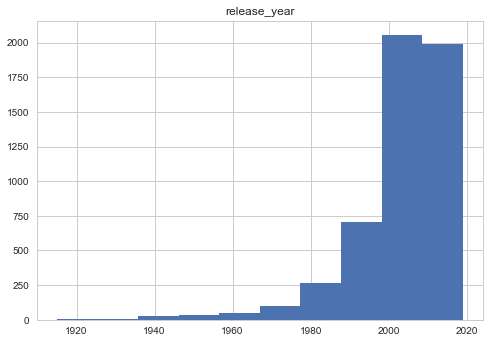

In [385]:
tn.hist('release_year')

In [386]:
tn = tn.loc[tn.query('(release_year <= 2019) & (release_year >= 2009)').index]
tn

,tn_id,release_date,release_year,movie,production_budget,domestic_gross,worldwide_gross,worldwide_profit,domestic_profit,worldwide_roi,domestic_roi
0,1,2009-12-18,2009,Avatar,425000000,760507625,2776345279,2351345279,335507625,553.257713,78.942971
1,2,2011-05-20,2011,Pirates of the Caribbean: On Stranger Tides,410600000,241063875,1045663875,635063875,-169536125,154.667286,-41.289850
2,3,2019-06-07,2019,Dark Phoenix,350000000,42762350,149762350,-200237650,-307237650,-57.210757,-87.782186
3,4,2015-05-01,2015,Avengers: Age of Ultron,330600000,459005868,1403013963,1072413963,128405868,324.384139,38.840250
4,5,2017-12-15,2017,Star Wars Ep. VIII: The Last Jedi,317000000,620181382,1316721747,999721747,303181382,315.369636,95.640815
...,...,...,...,...,...,...,...,...,...,...,...
5737,5738,2016-03-18,2016,Krisha,30000,144822,144822,114822,114822,382.740000,382.740000
5740,5741,2010-10-15,2010,Down Terrace,30000,9812,9812,-20188,-20188,-67.293333,-67.293333
5744,5745,2017-01-27,2017,Emily,27000,3547,3547,-23453,-23453,-86.862963,-86.862963
5760,5761,2010-04-02,2010,Breaking Upwards,15000,115592,115592,100592,100592,670.613333,670.613333


In [387]:
cleaning.info(tn)

,dup,dup_%,nan,nan_%,out,out_%
tn_id,0,0.000000,0,0.0,0.0,0.000000
release_date,1329,66.716867,0,0.0,NaN,NaN
release_year,1981,99.447791,0,0.0,0.0,0.000000
movie,4,0.200803,0,0.0,NaN,NaN
production_budget,1687,84.688755,0,0.0,216.0,10.843373
domestic_gross,0,0.000000,0,0.0,175.0,8.785141
worldwide_gross,0,0.000000,0,0.0,202.0,10.140562
worldwide_profit,0,0.000000,0,0.0,220.0,11.044177
domestic_profit,0,0.000000,0,0.0,252.0,12.650602
worldwide_roi,1,0.050201,0,0.0,144.0,7.228916


In [388]:
tn[tn[['movie']].duplicated(keep=False)]

,tn_id,release_date,release_year,movie,production_budget,domestic_gross,worldwide_gross,worldwide_profit,domestic_profit,worldwide_roi,domestic_roi
38,39,2010-05-14,2010,Robin Hood,210000000,105487148,322459006,112459006,-104512852,53.551908,-49.768025
243,244,2015-03-27,2015,Home,130000000,177397510,385997896,255997896,47397510,196.921458,36.459623
408,409,2018-11-21,2018,Robin Hood,99000000,30824628,84747441,-14252559,-68175372,-14.396524,-68.864012
2140,2141,2009-12-04,2009,Brothers,26000000,28544157,45043870,19043870,2544157,73.245654,9.785219
3307,3308,2015-08-14,2015,Brothers,13000000,656688,17856688,4856688,-12343312,37.359138,-94.948554
5009,5010,2010-04-09,2010,The Square,1900000,406216,740932,-1159068,-1493784,-61.003579,-78.620211
5099,5100,2013-10-25,2013,The Square,1500000,124244,176262,-1323738,-1375756,-88.249200,-91.717067
5459,5460,2009-04-23,2009,Home,500000,15433,44793168,44293168,-484567,8858.633600,-96.913400


In [389]:
tn.to_json(os.path.join('precomputed', 'tn.profit.json'))

In [390]:
imdb = pd.read_csv(os.path.join('zippedData', 'imdb.title.basics.csv.gz'))
imdb

,tconst,primary_title,original_title,start_year,runtime_minutes,genres
0,tt0063540,Sunghursh,Sunghursh,2013,175.0,"Action,Crime,Drama"
1,tt0066787,One Day Before the Rainy Season,Ashad Ka Ek Din,2019,114.0,"Biography,Drama"
2,tt0069049,The Other Side of the Wind,The Other Side of the Wind,2018,122.0,Drama
3,tt0069204,Sabse Bada Sukh,Sabse Bada Sukh,2018,NaN,"Comedy,Drama"
4,tt0100275,The Wandering Soap Opera,La Telenovela Errante,2017,80.0,"Comedy,Drama,Fantasy"
...,...,...,...,...,...,...
146139,tt9916538,Kuambil Lagi Hatiku,Kuambil Lagi Hatiku,2019,123.0,Drama
146140,tt9916622,Rodolpho Teóphilo - O Legado de um Pioneiro,Rodolpho Teóphilo - O Legado de um Pioneiro,2015,NaN,Documentary
146141,tt9916706,Dankyavar Danka,Dankyavar Danka,2013,NaN,Comedy
146142,tt9916730,6 Gunn,6 Gunn,2017,116.0,NaN


In [391]:
cleaning.info(imdb)

,dup,dup_%,nan,nan_%,out,out_%
runtime_minutes,145776,99.748194,31739,21.717621,6828.0,4.672104
genres,145058,99.256897,5408,3.700460,NaN,NaN
original_title,8370,5.727228,21,0.014369,NaN,NaN
tconst,0,0.000000,0,0.000000,NaN,NaN
primary_title,10073,6.892517,0,0.000000,NaN,NaN
start_year,146125,99.986999,0,0.000000,4.0,0.002737


In [392]:
imdb[imdb[['primary_title', 'original_title', 'start_year']].duplicated(keep=False)].sort_values('primary_title')

,tconst,primary_title,original_title,start_year,runtime_minutes,genres
103890,tt6085916,(aguirre),(aguirre),2016,97.0,"Biography,Documentary"
106201,tt6214664,(aguirre),(aguirre),2016,98.0,"Biography,Comedy,Documentary"
129962,tt8032828,100 Milioni di bracciate,100 Milioni di bracciate,2017,NaN,Biography
129979,tt8034014,100 Milioni di bracciate,100 Milioni di bracciate,2017,NaN,Biography
20394,tt1855110,180,180,2011,121.0,"Drama,Romance"
...,...,...,...,...,...,...
66990,tt3815124,Ângelo de Sousa - Tudo o Que Sou Capaz,Ângelo de Sousa - Tudo o Que Sou Capaz,2010,60.0,"Biography,Documentary"
66992,tt3815128,Ângelo de Sousa - Tudo o Que Sou Capaz,Ângelo de Sousa - Tudo o Que Sou Capaz,2010,60.0,"Biography,Documentary"
66995,tt3815134,Ângelo de Sousa - Tudo o Que Sou Capaz,Ângelo de Sousa - Tudo o Que Sou Capaz,2010,60.0,"Biography,Documentary"
92592,tt5352034,Çagrilan,Çagrilan,2016,85.0,Horror


In [393]:
imdb.drop_duplicates(subset=['primary_title', 'original_title', 'start_year'], inplace=True)

In [394]:
imdb['clean_title'] = cleaning.process_strings(imdb.loc[:, 'primary_title'])
tn = tn.assign(clean_title=cleaning.process_strings(tn['movie']))

In [395]:
imdb = pd.merge(imdb, tn, how='inner', left_on=['start_year', 'clean_title'], right_on=['release_year', 'clean_title'])
imdb.head()

,tconst,primary_title,original_title,start_year,runtime_minutes,genres,clean_title,tn_id,release_date,release_year,movie,production_budget,domestic_gross,worldwide_gross,worldwide_profit,domestic_profit,worldwide_roi,domestic_roi
0,tt0359950,The Secret Life of Walter Mitty,The Secret Life of Walter Mitty,2013,114.0,"Adventure,Comedy,Drama",the secret life of walter mitty,437,2013-12-25,2013,The Secret Life of Walter Mitty,91000000,58236838,187861183,96861183,-32763162,106.440860,-36.003475
1,tt0365907,A Walk Among the Tombstones,A Walk Among the Tombstones,2014,114.0,"Action,Crime,Drama",a walk among the tombstones,2067,2014-09-19,2014,A Walk Among the Tombstones,28000000,26017685,62108587,34108587,-1982315,121.816382,-7.079696
2,tt0369610,Jurassic World,Jurassic World,2015,124.0,"Action,Adventure,Sci-Fi",jurassic world,34,2015-06-12,2015,Jurassic World,215000000,652270625,1648854864,1433854864,437270625,666.909239,203.381686
3,tt0376136,The Rum Diary,The Rum Diary,2011,119.0,"Comedy,Drama",the rum diary,1316,2011-10-28,2011,The Rum Diary,45000000,13109815,21544732,-23455268,-31890185,-52.122818,-70.867078
4,tt0383010,The Three Stooges,The Three Stooges,2012,92.0,"Comedy,Family",the three stooges,1904,2012-04-13,2012,The Three Stooges,30000000,44338224,54052249,24052249,14338224,80.174163,47.794080


In [396]:
imdb.describe()

,start_year,runtime_minutes,tn_id,release_year,production_budget,domestic_gross,worldwide_gross,worldwide_profit,domestic_profit,worldwide_roi,domestic_roi
count,1387.000000,1382.000000,1387.000000,1387.000000,1.387000e+03,1.387000e+03,1.387000e+03,1.387000e+03,1.387000e+03,1387.000000,1387.000000
mean,2013.873107,108.884226,2261.977650,2013.873107,4.917016e+07,6.300275e+07,1.570417e+08,1.078715e+08,1.383259e+07,303.126023,103.747602
std,2.635049,17.810888,1599.699772,2.635049,5.731555e+07,8.708240e+07,2.403814e+08,1.991377e+08,6.236094e+07,1246.462873,681.892613
min,2010.000000,4.000000,2.000000,2010.000000,2.700000e+04,3.880000e+02,5.280000e+02,-2.002376e+08,-3.072376e+08,-99.894400,-99.996120
25%,2012.000000,96.000000,834.500000,2012.000000,1.000000e+07,8.466156e+06,1.785669e+07,8.862905e+05,-1.182972e+07,10.303335,-52.953275
50%,2014.000000,106.000000,2054.000000,2014.000000,2.800000e+07,3.491298e+07,6.553249e+07,3.335931e+07,8.114170e+05,137.044727,4.179812
75%,2016.000000,118.750000,3554.500000,2016.000000,6.150000e+07,7.781173e+07,1.786305e+08,1.211787e+08,2.691266e+07,321.640324,111.359405
max,2019.000000,180.000000,5745.000000,2019.000000,4.106000e+08,7.000596e+08,2.048134e+09,1.748134e+09,5.000596e+08,41556.474000,22664.410000


In [397]:
imdb.drop(columns=['start_year', 'release_year', 'clean_title', 'movie', 'original_title', 'runtime_minutes'], inplace=True)

In [398]:
cleaning.info(imdb)

,dup,dup_%,nan,nan_%,out,out_%
tconst,0,0.000000,0,0.0,NaN,NaN
primary_title,14,1.009373,0,0.0,NaN,NaN
genres,1171,84.426820,0,0.0,NaN,NaN
tn_id,14,1.009373,0,0.0,0.0,0.000000
release_date,820,59.120404,0,0.0,NaN,NaN
production_budget,1146,82.624369,0,0.0,138.0,9.949531
domestic_gross,14,1.009373,0,0.0,109.0,7.858688
worldwide_gross,14,1.009373,0,0.0,140.0,10.093727
worldwide_profit,14,1.009373,0,0.0,146.0,10.526316
domestic_profit,14,1.009373,0,0.0,162.0,11.679885


In [399]:
imdb['genres'] = imdb.loc[:, 'genres'].str.split(',')
imdb[['genres']]

,genres
0,"[Adventure, Comedy, Drama]"
1,"[Action, Crime, Drama]"
2,"[Action, Adventure, Sci-Fi]"
3,"[Comedy, Drama]"
4,"[Comedy, Family]"
...,...
1382,"[Horror, Thriller]"
1383,"[Crime, Drama, Thriller]"
1384,"[Drama, Horror, Mystery]"
1385,[Documentary]


In [400]:
imdb.explode('genres')['genres'].value_counts()

Drama          671
Comedy         488
Action         421
Adventure      345
Thriller       235
Crime          214
Romance        183
Horror         150
Sci-Fi         129
Biography      129
Fantasy        120
Mystery        115
Animation      100
Family          87
Music           50
History         39
Documentary     35
Sport           32
War             17
Western         10
Musical          9
Name: genres, dtype: int64

In [401]:
# Collapse Music and Musical
imdb.explode('genres').query('genres == "Music"').head()

,tconst,primary_title,genres,tn_id,release_date,production_budget,domestic_gross,worldwide_gross,worldwide_profit,domestic_profit,worldwide_roi,domestic_roi
30,tt0475290,"Hail, Caesar!",Music,2422,2016-02-05,22000000,30080225,64160680,42160680,8080225,191.639455,36.728295
128,tt1017451,The Runaways,Music,3757,2010-03-19,9500000,3573673,5278632,-4221368,-5926327,-44.435453,-62.382389
152,tt1068242,Footloose,Music,2339,2011-10-14,24000000,51802742,62989834,38989834,27802742,162.457642,115.844758
170,tt1126591,Burlesque,Music,1024,2010-11-24,55000000,39440655,90552675,35552675,-15559345,64.641227,-28.289718
195,tt1193631,Step Up 3D,Music,1909,2010-08-06,30000000,42400223,165889117,135889117,12400223,452.963723,41.334077


In [402]:
imdb['genres'] = utils.map_list_likes(imdb['genres'], lambda x: 'Musical' if x == 'Music' else x)
imdb.explode('genres').query('genres == "Music"')

,tconst,primary_title,genres,tn_id,release_date,production_budget,domestic_gross,worldwide_gross,worldwide_profit,domestic_profit,worldwide_roi,domestic_roi


In [403]:
imdb.to_json(os.path.join('cleanData', 'imdb.tn.basics.json'))

<AxesSubplot:ylabel='primary_title'>

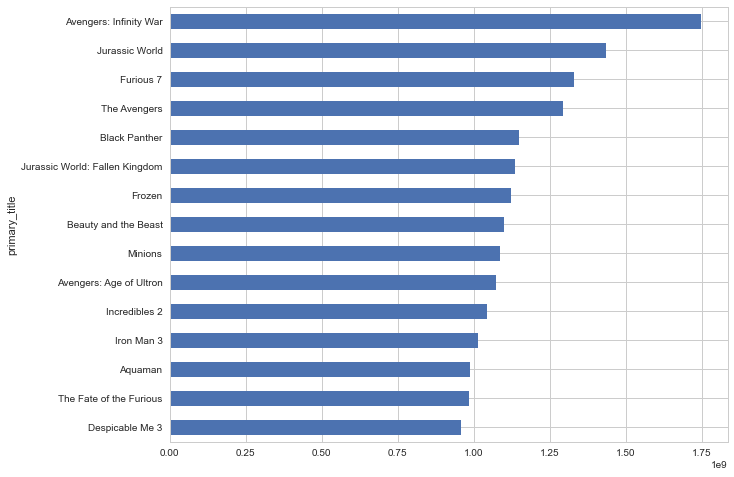

In [404]:
top_profit = imdb[['primary_title','worldwide_profit']].sort_values('worldwide_profit').tail(15)
top_profit.set_index('primary_title').plot.barh(figsize=(10, 8), legend=False)

In [405]:
imdb['profit_decile'] = pd.qcut(imdb['worldwide_profit'], 10, labels=range(10))

<AxesSubplot:>

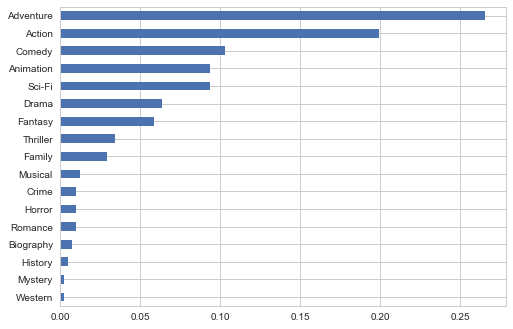

In [406]:
imdb.explode('genres').query('profit_decile == 9')['genres'].value_counts(normalize=True)[::-1].plot.barh()

<AxesSubplot:>

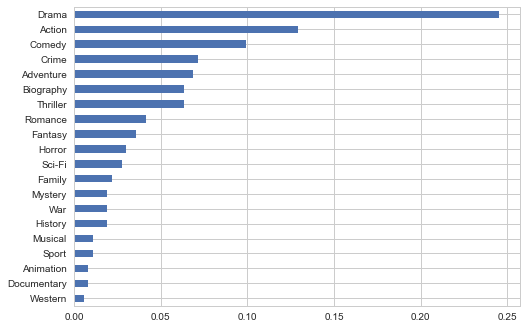

In [407]:
imdb.explode('genres').query('profit_decile == 0')['genres'].value_counts(normalize=True)[::-1].plot.barh()

<AxesSubplot:ylabel='genres'>

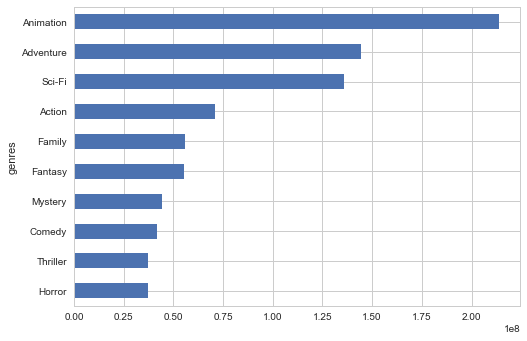

In [415]:
imdb.explode('genres').groupby('genres')['worldwide_profit'].median().sort_values().tail(10).plot.barh()

In [409]:
combos = pd.crosstab(imdb.explode('genres')['tconst'], imdb.explode('genres')['genres'])
combos = combos.sort_index(axis=1).sort_index(axis=0)
combos.to_json(os.path.join('precomputed', 'genre_combos.json'))
combos.head()

genres,Action,Adventure,Animation,Biography,Comedy,Crime,Documentary,Drama,Family,Fantasy,History,Horror,Musical,Mystery,Romance,Sci-Fi,Sport,Thriller,War,Western
tconst,,,,,,,,,,,,,,,,,,,,
tt0359950,0,1,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0
tt0365907,1,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0
tt0369610,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0
tt0376136,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0
tt0383010,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0


Text(0.5, 1.0, 'Genre Correlation with Worldwide Profit')

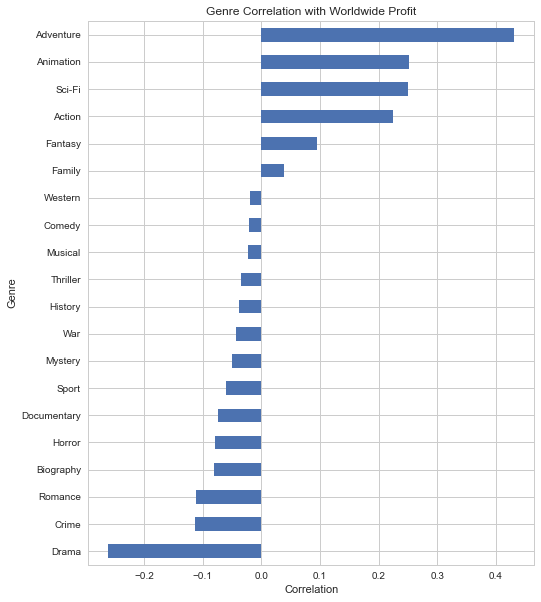

In [410]:
imdb.set_index('tconst', inplace=True)
ax = combos.corrwith(imdb['worldwide_profit']).sort_values().plot.barh(figsize=(8, 10))
ax.set_xlabel('Correlation')
ax.set_ylabel('Genre')
ax.set_title('Genre Correlation with Worldwide Profit')

Text(0.5, 1.0, 'Genre Correlation with Worldwide ROI')

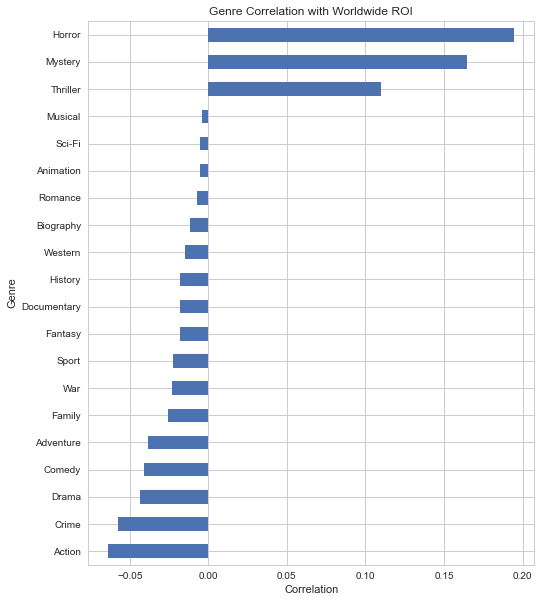

In [411]:
ax = combos.corrwith(imdb['worldwide_roi']).sort_values().plot.barh(figsize=(8, 10))
ax.set_xlabel('Correlation')
ax.set_ylabel('Genre')
ax.set_title('Genre Correlation with Worldwide ROI')

In [427]:
imdb['budget_decile'] = pd.qcut(imdb['production_budget'], 4, range(4))
roi_by_budget = combos.groupby(imdb['budget_decile']).corrwith(imdb['worldwide_roi'])
roi_by_budget

genres,Action,Adventure,Animation,Biography,Comedy,Crime,Documentary,Drama,Family,Fantasy,History,Horror,Musical,Mystery,Romance,Sci-Fi,Sport,Thriller,War,Western
budget_decile,,,,,,,,,,,,,,,,,,,,
0,-0.047521,-0.036441,-0.017651,-0.031670,-0.082093,-0.058842,-0.048967,-0.120664,-0.039040,0.003213,-0.034934,0.246581,-0.041728,0.226627,-0.038139,-0.013672,-0.028522,0.178806,-0.025737,-0.023738
1,-0.114143,-0.043319,-0.006251,0.046910,0.039027,-0.125034,0.004846,0.023442,0.001859,-0.010431,0.011532,0.098724,0.032823,0.036655,0.023208,0.037576,-0.053416,0.053308,-0.082967,-0.039019
2,-0.021730,-0.043935,-0.019407,-0.016470,-0.034357,-0.124481,-0.048794,-0.042146,-0.041521,-0.058455,-0.009947,0.021595,0.163115,0.027535,0.113471,0.041737,-0.013892,0.099117,-0.057770,0.015137
3,-0.148393,0.153590,0.245077,0.009019,0.137946,-0.069370,-0.024475,-0.119603,-0.026314,-0.072886,-0.020623,-0.096173,0.090657,-0.024382,-0.108490,0.093229,-0.046550,-0.054345,-0.025478,-0.034459


In [508]:
display(pd.qcut(imdb['production_budget'], 4).dtype.categories)
np.percentile(imdb['production_budget'].values, [25, 50, 75])

IntervalIndex([(26999.999, 10000000.0], (10000000.0, 28000000.0], (28000000.0, 61500000.0], (61500000.0, 410600000.0]],
              closed='right',
              dtype='interval[float64]')

array([10000000., 28000000., 61500000.])

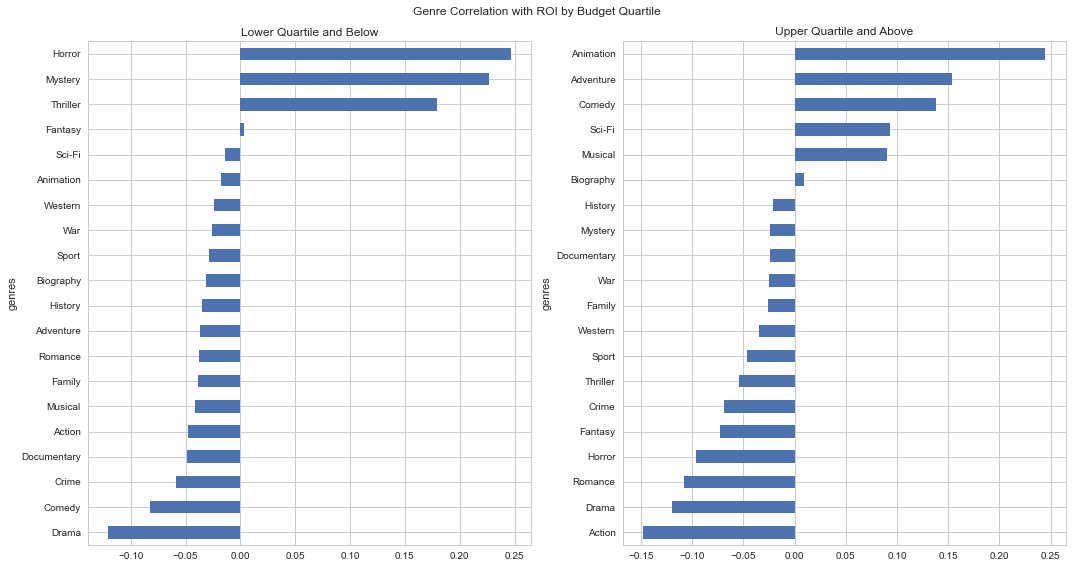

In [503]:
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(15, 8))
ax1 = roi_by_budget.loc[0].sort_values().plot.barh(ax=ax1)
ax2 = roi_by_budget.loc[3].sort_values().plot.barh(ax=ax2)
ax1.set_title(f'Lower Quartile and Below')
ax2.set_title(f'Upper Quartile and Above')
fig.suptitle('Genre Correlation with ROI by Budget Quartile')
fig.tight_layout()

Text(0.5, 1.0, 'Median to Upper Quartile')

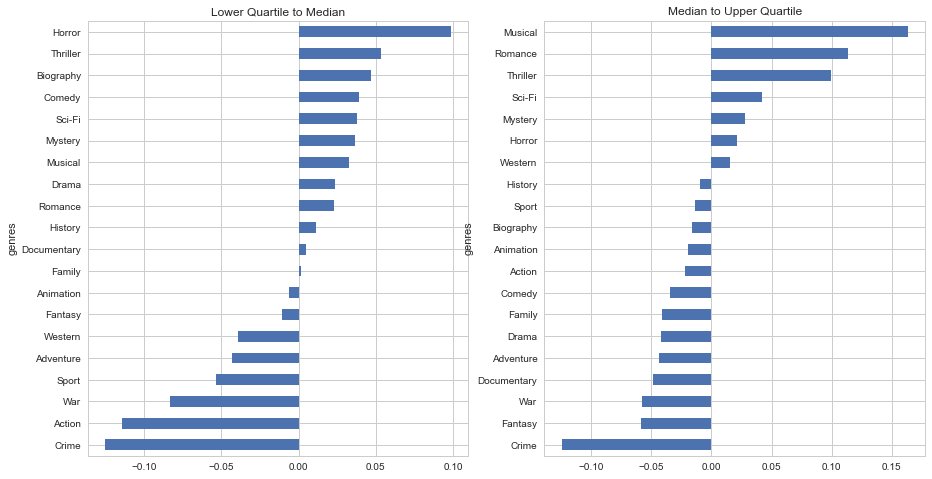

In [504]:
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(15, 8))
ax1 = roi_by_budget.loc[1].sort_values().plot.barh(ax=ax1)
ax2 = roi_by_budget.loc[2].sort_values().plot.barh(ax=ax2)
ax1.set_title(f'Lower Quartile to Median')
ax2.set_title(f'Median to Upper Quartile')